## RFM模型客户价值分析（python）

#### 问题描述
- 根据所提供的零售商的实际交易数据，使用RFM模型对客户进行价值分类。
- 从用户、地区和时间等维度分析用户行为并提出优化建议。

#### 数据说明
英国零售商的实际交易数据，包含了2010年12月1日至2011年12月9日在英国注册的非实体网上零售发生的所有交易。公司主要销售独特的全天候礼品。该公司的许多客户都是批发商。

| 字段        | 字段说明                       |
| ----------- | ------------------------------ |
| InvoiceNo   | 订单号码：6位字符串            |
| StockCode   | 产品代码：6位字符串            |
| Description | 产品描述                       |
| Quantity    | 产品数量：交易产品数量         |
| InvoiceDate | 订单日期：订单发生的日期和时间 |
| UnitPrice   | 单价：浮点数值                 |
| CustomerID  | 顾客ID：5位字符串              |
| Country     | 国家：客户所在地               |


#### 数据来源
https://www.kaggle.com/datasets/carrie1/ecommerce-data


### 1、了解数据
#### 1）导入库

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')
import os
import datetime
from sklearn.cluster import KMeans

# 显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


#### 2）读取查看数据

In [2]:
path = './data/data.csv'
df = pd.read_csv(path, dtype={'CustomerID': str, 'InvoiceID': str})

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


#### 3）查看数据类型和数据结构

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


可以看到Quantity、UnitPrice存在异常数据

#### 4）统计缺失值

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 2、处理数据

#### 1）去除重复数据

In [7]:
df.drop_duplicates(inplace=True)

#### 2）处理异常数据

In [8]:
# 查看异常值数量
print(df.loc[df['UnitPrice'] < 0].UnitPrice.count())
print(df.loc[df['Quantity'] < 0].Quantity.count())

2
10587


In [9]:
# 查看异常值数据的描述信息
df.loc[df['UnitPrice'] < 0, ['UnitPrice', 'Description']]

,UnitPrice,Description
299983,-11062.06,Adjust bad debt
299984,-11062.06,Adjust bad debt


In [10]:
df.loc[df['Quantity'] < 0, ['Quantity', 'Description']].tail()

,Quantity,Description
540449,-11,ZINC T-LIGHT HOLDER STARS SMALL
541541,-1,Manual
541715,-5,VICTORIAN SEWING BOX LARGE
541716,-1,HANGING HEART JAR T-LIGHT HOLDER
541717,-5,36 PENCILS TUBE RED RETROSPOT


In [11]:
# 去除UnitPrice小于0的和Quantity小于0的数据
df = df[(df['UnitPrice'] >= 0) & (df['Quantity'] > 0)]

#### 3）处理缺失值

In [12]:
# 统计缺失值
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133320
Country             0
dtype: int64

In [13]:
# 统计缺失值占比
df.isnull().sum()/df.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.112536
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.343502
Country         0.000000
dtype: float64

因为后续的分析中需要用到客户ID，且客户ID的缺失占比在可接受的范围内，所以删除Customer为空的数据

In [14]:
df = df[~(df.CustomerID.isnull())]

#### 4）调整数据类型

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  object        
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [17]:
# 查看订单交易时间范围
print('min InvoiceDate: ', df['InvoiceDate'].min())
print('max InvoiceDate: ', df['InvoiceDate'].max())

min InvoiceDate:  2010-12-01 08:26:00
max InvoiceDate:  2011-12-09 12:50:00


### 3、数据分析

#### 1）数据准备, 构建RFM数据

In [18]:
# 添加一列Sales
df['Sales'] = df['Quantity']*df['UnitPrice']

In [19]:
# 去除重复数据，计算购买频率
df_f = df
df_f.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep='first', inplace=True)

frequency_df = df_f.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.set_index('CustomerID', drop=True, inplace=True)
frequency_df.head()

,Frequency
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1


这里需要计算客户最后一次下订单距离当前日期的天数距离，
因为这里是2010-2011年的数据，这里把当前日期设置为2012-01-01
距离天数即为客户最后一次交易日期距离2012-01-01的天数

In [20]:
# 按用户ID分组计算总销售金额、最后一次交易的日期距离2012-01-01的天数
df_rm = df.groupby('CustomerID').agg({'Sales': 'sum', 'InvoiceDate': 'max'})

df_rm['DateDiff'] = (pd.to_datetime('2012-01-01') - df_rm['InvoiceDate']).dt.days

# 删除InvoiceDate字段列
df_rm = df_rm.drop('InvoiceDate', axis=1)
df_rm.head()


,Sales,DateDiff
CustomerID,,
12346,77183.60,347
12347,163.16,24
12348,331.36,97
12349,15.00,40
12350,25.20,332


In [21]:
# 合并数据
df_rfm = df_rm.merge(frequency_df, on='CustomerID')
df_rfm.head()

,Sales,DateDiff,Frequency
CustomerID,,,
12346,77183.60,347,1
12347,163.16,24,7
12348,331.36,97,4
12349,15.00,40,1
12350,25.20,332,1


#### 2）RFM模型用户分类、数据可视化

**查看数据大概分布**

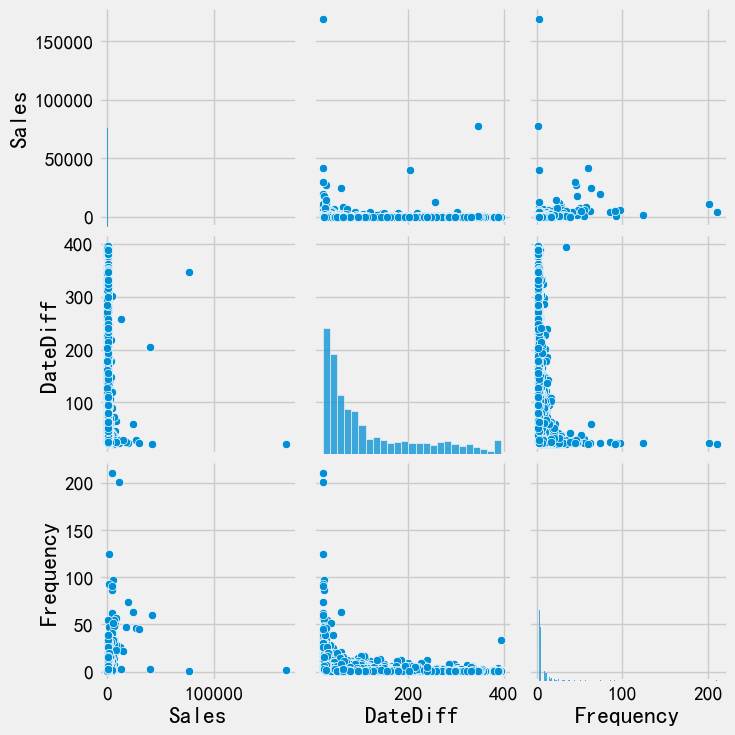

In [22]:
sns.pairplot(df_rfm)

**单独看分布直方图**

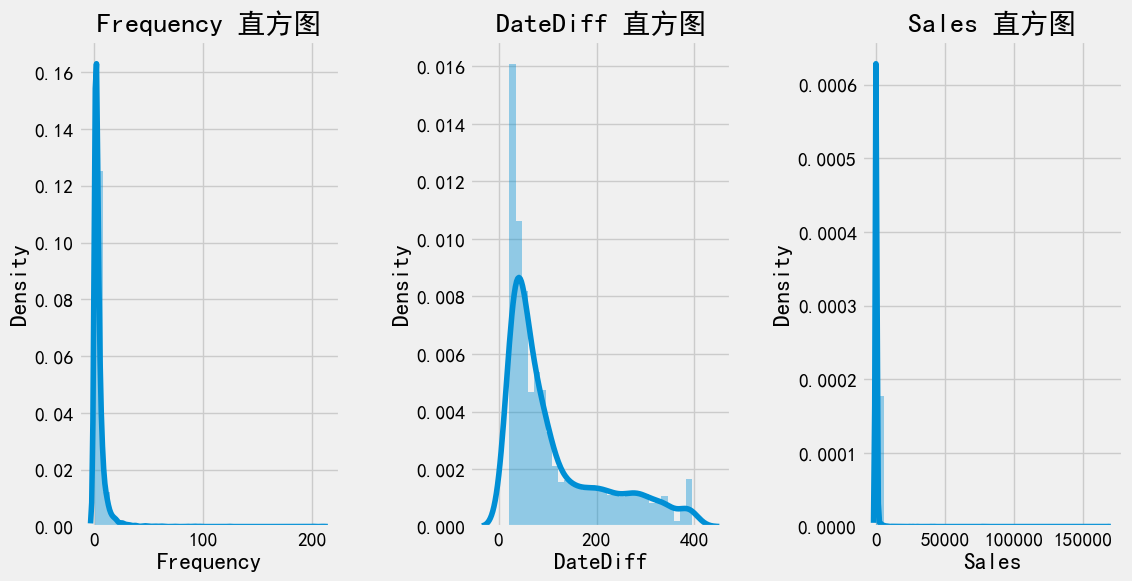

In [23]:
plt.figure(1, figsize=(12, 6))
n = 0
for x in ['Frequency', 'DateDiff', 'Sales']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.distplot(df_rfm[x], bins=30)
    plt.title('{} 直方图'.format(x))
plt.show()

#### 3）RFM模型

| 含义         | 说明         | 在本实例中的定义                   |
| ------------ | ------------ | ---------------------------------- |
| R : Recency  | 最近一次消费 | 每个客户最近一次下单距离现在的天数 |
| F: Frequency | 消费频率     | 每个客户累计单数                   |
| M: Monetary  | 消费金额     | 每个客户累计交易金额               |

- 根据客户的消费间隔、频率和贡献金额把客户分为8个类型
- 通过分布直方图发现，该份数据不适合使用中位数作为划分阈值，而应该使用R、F、M的均值对数据进行分层

In [24]:
rmd = df_rfm['DateDiff'].mean()   # 最近一次消费
fmd = df_rfm['Frequency'].mean()  # 消费频率
mmd = df_rfm['Sales'].mean()      # 消费金额
rmd, fmd, mmd

(114.0414842129523, 4.271952062687255, 296.7611131597142)

In [25]:
df_rfm.head(2)

,Sales,DateDiff,Frequency
CustomerID,,,
12346,77183.60,347,1
12347,163.16,24,7


In [26]:
def customer_class(frame):
    customer_type = []
    for i in range(len(frame)): # recency  frequency  money
        if frame.iloc[i, 1] <= rmd and frame.iloc[i, 2] >= fmd and frame.iloc[i, 0] >= mmd:
            customer_type.append('重要价值客户')
        elif frame.iloc[i, 1] > rmd and frame.iloc[i, 2] >= fmd and frame.iloc[i, 0] >= mmd:
            customer_type.append('重要唤回用户')
        elif frame.iloc[i, 1] <= rmd and frame.iloc[i, 2] < fmd and frame.iloc[i, 0] >= mmd:
            customer_type.append('重要深耕用户')
        elif frame.iloc[i, 1] > rmd and frame.iloc[i, 2] < fmd and frame.iloc[i, 0] >= mmd:
            customer_type.append('重要挽留客户')
        elif frame.iloc[i, 1] <= rmd and frame.iloc[i, 2] >= fmd and frame.iloc[i, 0] < mmd:
            customer_type.append('潜力用户')
        elif frame.iloc[i, 1] > rmd and frame.iloc[i, 2] >= fmd and frame.iloc[i, 0] < mmd:
            customer_type.append('一般维持用户')
        elif frame.iloc[i, 1] <= rmd and frame.iloc[i, 2] < fmd and frame.iloc[i, 0] < mmd:
            customer_type.append('新用户')
        elif frame.iloc[i, 1] > rmd and frame.iloc[i, 2] < fmd and frame.iloc[i, 0] < mmd:
            customer_type.append('流失用户')
    frame['classification'] = customer_type
    return frame

In [27]:
df_rfm = customer_class(df_rfm)
df_rfm.head()

,Sales,DateDiff,Frequency,classification
CustomerID,,,,
12346,77183.60,347,1,重要挽留客户
12347,163.16,24,7,潜力用户
12348,331.36,97,4,重要深耕用户
12349,15.00,40,1,新用户
12350,25.20,332,1,流失用户


**不同类型的客户总数**

In [28]:
df_rfm.groupby(by='classification').size().reset_index(name='客户数')

,classification,客户数
0,一般维持用户,51
1,新用户,1803
2,流失用户,1298
3,潜力用户,686
4,重要价值客户,361
5,重要唤回用户,17
6,重要挽留客户,58
7,重要深耕用户,65


**不同类型的客户消费总额**

In [29]:
df_rfm.groupby('classification').Sales.sum().reset_index(name='金额')

,classification,金额
0,一般维持用户,6332.64
1,新用户,89209.31
2,流失用户,53116.41
3,潜力用户,93804.10
4,重要价值客户,617878.42
5,重要唤回用户,22002.41
6,重要挽留客户,168550.12
7,重要深耕用户,236753.06


**不同类型客户数量可视化**

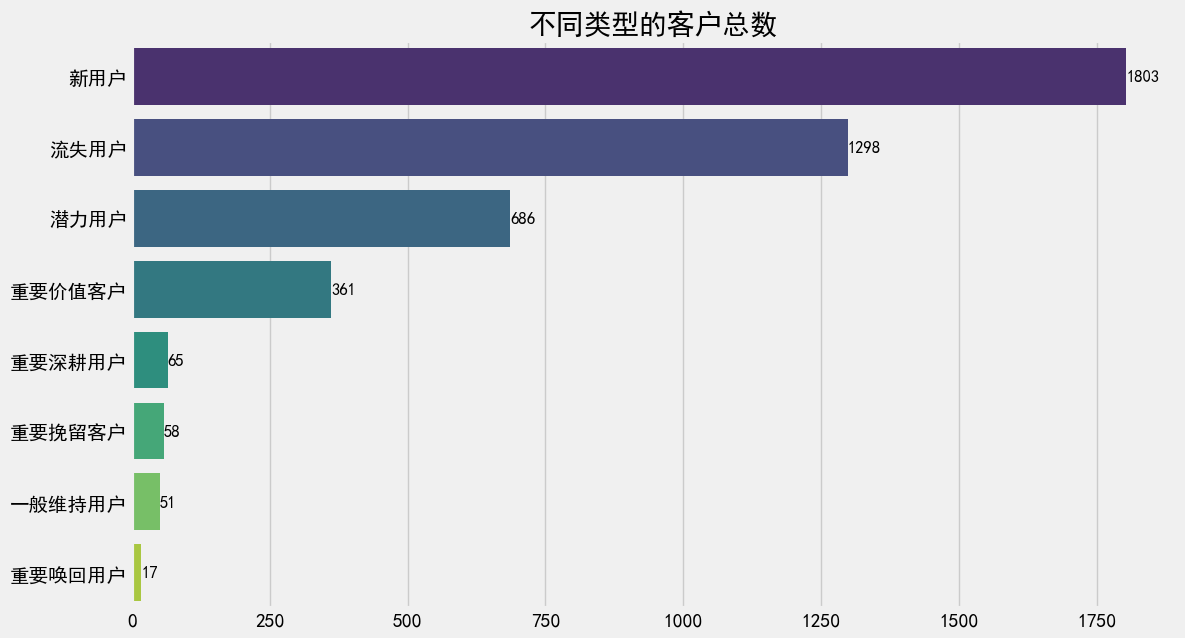

In [30]:
plt.figure(2, figsize=(12, 7))
sns.countplot(y='classification', order=df_rfm['classification'].value_counts().index, data=df_rfm, palette='viridis')
plt.title('不同类型的客户总数', fontsize=20)
plt.xlabel('')
plt.ylabel('')
con = list(df_rfm.groupby('classification').classification.count().values)
con = sorted(con, reverse=True)
for x, y in enumerate(con):
    plt.text(y+0.3, x, '%s' % y, va='center', size=12)
plt.show()

**不同类型的客户消费份额**

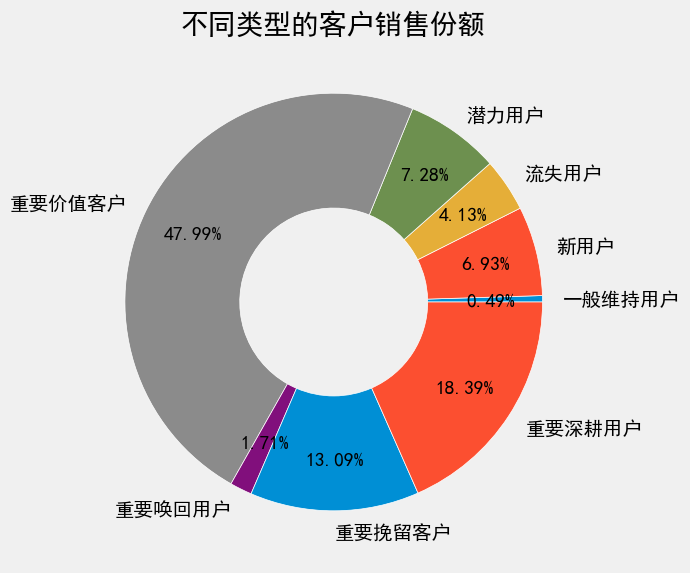

In [31]:
plt.figure(3, figsize=(6, 8))
labels = df_rfm.groupby('classification').Sales.sum().index
size = df_rfm.groupby('classification').Sales.sum()

plt.pie(size, labels=labels, autopct='%.2f%%', wedgeprops={'width': 0.55, 'edgecolor': 'w'}, pctdistance=0.75)
plt.title('不同类型的客户销售份额', fontsize=20)
plt.axis('off')
plt.show()

**客户的国家地区分布**

In [32]:
df_country_customer = df.drop_duplicates(['Country', 'CustomerID']).groupby('Country', as_index=False).CustomerID.count().sort_values('CustomerID', ascending=False, ignore_index=True)
df_country_customer.columns = ['国家或地区', '客户人数']
df_country_customer


,国家或地区,客户人数
0,United Kingdom,3921
1,Germany,94
2,France,87
3,Spain,30
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,14
8,Finland,12
9,Austria,11


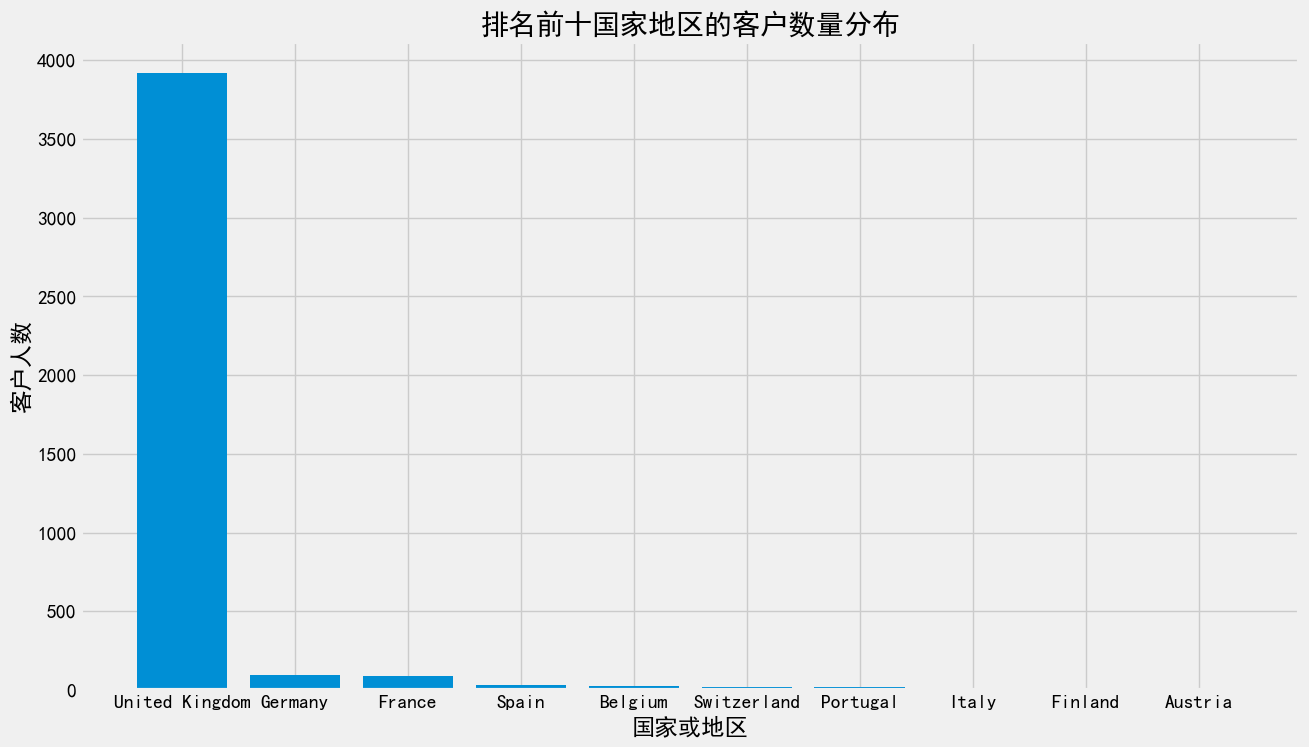

In [33]:
plt.figure(4, figsize=(14, 8))
plt.bar(df_country_customer.iloc[:10]['国家或地区'], df_country_customer.iloc[:10]['客户人数'])

plt.title('排名前十国家地区的客户数量分布')
plt.xlabel('国家或地区')
plt.ylabel('客户人数')
plt.show()

因为是英国的电商公司，所以客户群体主要集中在英国内地，从客户分布来看，德国和法国有一定的客户群体，公司如果开展海外业务，应优先选择德国和法国作为公司的海外市场发展方向。

**产品销量与销售额矩阵**

In [34]:
df_mat = df.groupby('StockCode', as_index=False).agg({'Quantity': 'sum', 'Sales': 'sum'})
df_mat['StockCode'] = df_mat['StockCode'].astype('str')
df_mat

,StockCode,Quantity,Sales
0,10002,133,113.05
1,10080,66,25.74
2,10120,1,0.21
3,10123C,2,1.30
4,10125,61,43.25
...,...,...,...
2544,90214S,2,2.50
2545,BANK CHARGES,11,165.00
2546,C2,13,725.00
2547,M,4582,44416.65


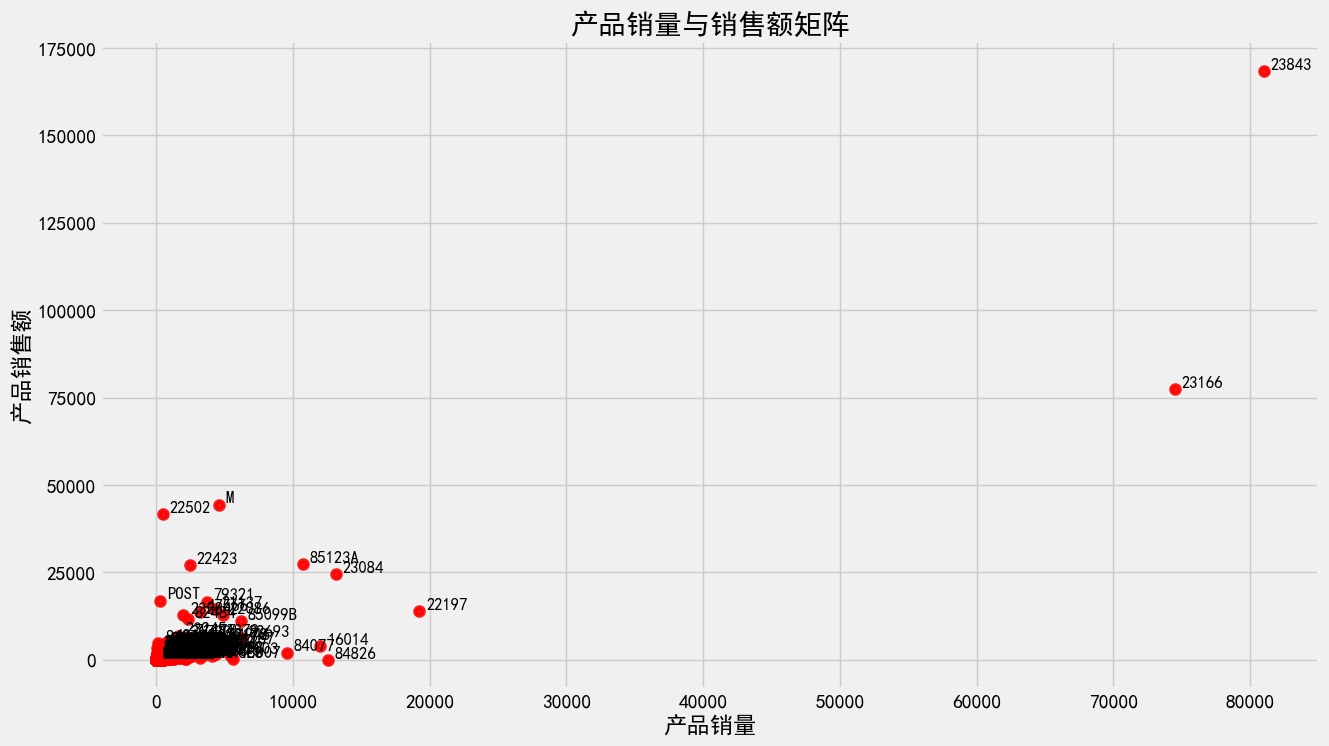

In [35]:
plt.figure(5, figsize=(14, 8))
plt.scatter(df_mat['Quantity'], df_mat['Sales'], c='r', marker='o', alpha=0.9, linewidths=3)
for i in range(len(df_mat)):
    plt.text(df_mat['Quantity'][i] + 500, df_mat['Sales'][i] + 500, s=df_mat['StockCode'][i], fontsize=12)
plt.title('产品销量与销售额矩阵')
plt.xlabel('产品销量')
plt.ylabel('产品销售额')
plt.show()